In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from functions.poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.optimize import curve_fit
from itertools import starmap

from sklearn.metrics import r2_score
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# Prepare data

## Percent voting people

In [3]:
voter_w = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

In [4]:
voter_w

,0,1
0,DOLNOŚLĄSKIE,0.074539
1,KUJAWSKO-POMORSKIE,0.048856
2,LUBELSKIE,0.054023
3,LUBUSKIE,0.023268
4,MAZOWIECKIE,0.163130
5,MAŁOPOLSKIE,0.091426
6,OPOLSKIE,0.022504
7,PODKARPACKIE,0.054042
8,PODLASKIE,0.028713
9,POMORSKIE,0.060520


## Poll data

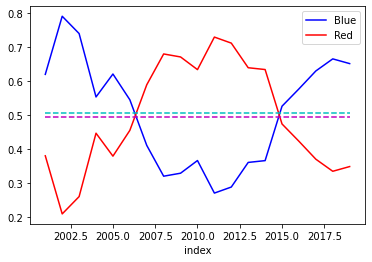

In [4]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/no_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [5]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [6]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [7]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [8]:
vote_list[0] = vote_list[0].set_index('województwo')

## Neighbours

In [9]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Stat data

In [10]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [11]:
stat_list_org = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files]

In [12]:
stat_list_org[0].columns[stat_list_org[0].isna().sum(0) > 0]

Index(['bezrobocie_zarejsestrowane_gminy', 'ludnosc_na_1km2',
       'dochody_na_mieszkanca', 'wyksztalcenie_wyzsze',
       'udzial_wiek_przedprodukcyjny', 'udzial_wiek_produkcyjny',
       'udzial_wiek_poprodukcyjny', 'socjal_500plus', 'przestepstwa_ogolem'],
      dtype='object')

In [13]:
data = [['mazowieckie',35558], 
['wielkopolskie',29826], 
['lubelskie',25122], 
['warmińsko-mazurskie',24173], 
['zachodniopomorskie',22892], 
['podlaskie',20187], 
['dolnośląskie',19947], 
['pomorskie',18310], 
['łódzkie',18219], 
['kujawsko-pomorskie',17972], 
['podkarpackie',17846], 
['małopolskie',15183], 
['lubuskie',13988], 
['śląskie',12333], 
['świętokrzyskie',11711], 
['opolskie',9412]]

woj_pow = pd.DataFrame(data, columns=['jednostka','powierzchnnia_km2'])

In [14]:
woj_pow['jednostka'] = woj_pow['jednostka'] .str.upper() 

In [15]:
for s in range(len(stat_list_org)):
    stat_list_org[s] = pd.merge(stat_list_org[s], woj_pow, left_index=True, right_on='jednostka')
    stat_list_org[s] = stat_list_org[s].set_index('jednostka')

## Use 2 approaches to estimate date from years without elections

In [16]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [17]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]

In [18]:
pool_d = par_in_reg_list if (False) else reg_in_par_list 

In [19]:
pool_d_plot = []
voter_percent = voter_w.iloc[:,1].values
for p in pool_d:
    pool_d_plot.append(np.average(np.average(p['Blue'].values,weights = voter_percent)))

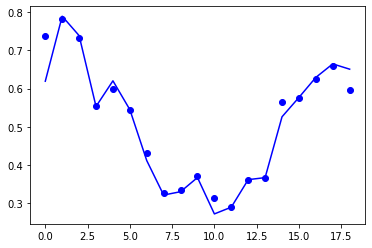

In [20]:
plt.plot(pool_d_plot,'bo')
plt.plot(pool_data_middle['Blue'].values ,'b-')
plt.show()

### Correlation
Corr between real data before scaling and outpots for each party based on rescaled output with poll and real data

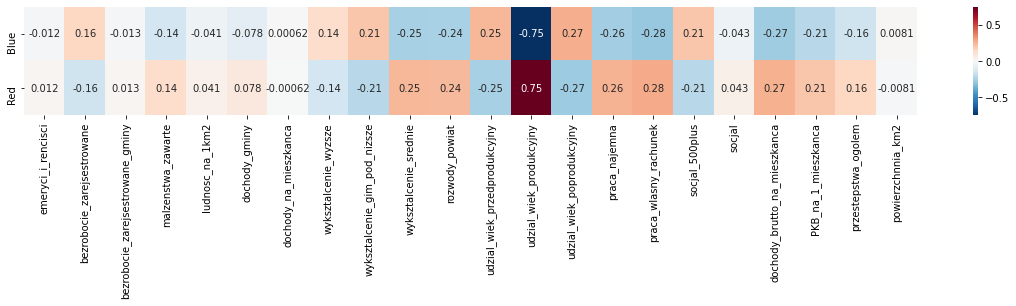

In [21]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20,2))
sn.heatmap(pool_stat_df_org.corr().iloc[-2:,:-2], annot=True, cmap='RdBu_r', ax=ax)
plt.savefig('dane_pdf/dane_stat/all_correlations.pdf',  bbox_inches='tight')

In [22]:
(pool_stat_df_org
                       .corr()
                       .iloc[-2:,:-2][pool_stat_df_org
                                      .corr()
                                      .iloc[-2:,:-2]
                                      .abs() > 0.1])

,emeryci_i_rencisci,bezrobocie_zarejsestrowane,bezrobocie_zarejsestrowane_gminy,malzenstwa_zawarte,ludnosc_na_1km2,dochody_gminy,dochody_na_mieszkanca,wyksztalcenie_wyzsze,wyksztalcenie_gim_pod_nizsze,wyksztalcenie_srednie,...,udzial_wiek_produkcyjny,udzial_wiek_poprodukcyjny,praca_najemna,praca_wlasny_rachunek,socjal_500plus,socjal,dochody_brutto_na_mieszkanca,PKB_na_1_mieszkanca,przestepstwa_ogolem,powierzchnnia_km2
Blue,NaN,0.155267,NaN,-0.135066,NaN,NaN,NaN,0.136189,0.205325,-0.247968,...,-0.747516,0.270503,-0.261207,-0.280812,0.20763,NaN,-0.26749,-0.210211,-0.156699,NaN
Red,NaN,-0.155267,NaN,0.135066,NaN,NaN,NaN,-0.136189,-0.205325,0.247968,...,0.747516,-0.270503,0.261207,0.280812,-0.20763,NaN,0.26749,0.210211,0.156699,NaN


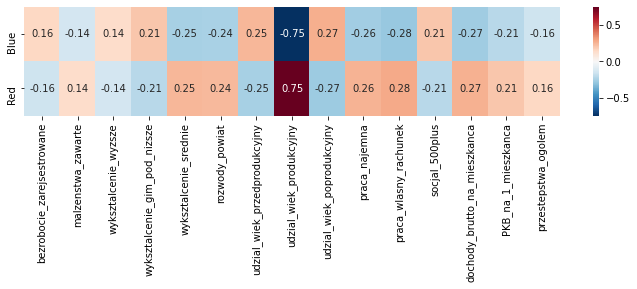

In [23]:
fig, ax = plt.subplots(figsize=(12,2))
pool_names_highcorr = (pool_stat_df_org
                       .corr()
                       .iloc[-2:,:-2][pool_stat_df_org
                                      .corr()
                                      .iloc[-2:,:-2]
                                      .abs() > 0.1]
                       .dropna(1))
sn.heatmap(pool_names_highcorr.dropna(1), annot=True, cmap='RdBu_r', ax=ax)
plt.savefig('dane_pdf/dane_stat/all_correlations_choosed.pdf',  bbox_inches='tight')

In [24]:
pool_names_highcorr

,bezrobocie_zarejsestrowane,malzenstwa_zawarte,wyksztalcenie_wyzsze,wyksztalcenie_gim_pod_nizsze,wyksztalcenie_srednie,rozwody_powiat,udzial_wiek_przedprodukcyjny,udzial_wiek_produkcyjny,udzial_wiek_poprodukcyjny,praca_najemna,praca_wlasny_rachunek,socjal_500plus,dochody_brutto_na_mieszkanca,PKB_na_1_mieszkanca,przestepstwa_ogolem
Blue,0.155267,-0.135066,0.136189,0.205325,-0.247968,-0.243936,0.24773,-0.747516,0.270503,-0.261207,-0.280812,0.20763,-0.26749,-0.210211,-0.156699
Red,-0.155267,0.135066,-0.136189,-0.205325,0.247968,0.243936,-0.24773,0.747516,-0.270503,0.261207,0.280812,-0.20763,0.26749,0.210211,0.156699


In [25]:
col_highcorr = pool_names_highcorr.columns.values.tolist()

In [26]:
for ch in col_highcorr:
    print('\item',ch )

\item bezrobocie_zarejsestrowane
\item malzenstwa_zawarte
\item wyksztalcenie_wyzsze
\item wyksztalcenie_gim_pod_nizsze
\item wyksztalcenie_srednie
\item rozwody_powiat
\item udzial_wiek_przedprodukcyjny
\item udzial_wiek_produkcyjny
\item udzial_wiek_poprodukcyjny
\item praca_najemna
\item praca_wlasny_rachunek
\item socjal_500plus
\item dochody_brutto_na_mieszkanca
\item PKB_na_1_mieszkanca
\item przestepstwa_ogolem


In [27]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [28]:
df1_null = stat_list_org[0].count()
col_df1_null = df1_null[df1_null==0].index.values.tolist()

In [29]:
col_df1_null

['bezrobocie_zarejsestrowane_gminy',
 'ludnosc_na_1km2',
 'dochody_na_mieszkanca',
 'udzial_wiek_przedprodukcyjny',
 'udzial_wiek_produkcyjny',
 'udzial_wiek_poprodukcyjny',
 'socjal_500plus',
 'przestepstwa_ogolem']

In [30]:
cols_to_fill = list(set(col_df1_null).intersection(col_highcorr))
cols_to_fill = cols_to_fill[1:]
cols_to_fill

['przestepstwa_ogolem',
 'udzial_wiek_przedprodukcyjny',
 'socjal_500plus',
 'udzial_wiek_produkcyjny']

In [31]:
dflast_null = stat_list_org[-1].count()
col_dflast_null = dflast_null[dflast_null==0].index.values.tolist()
cols_to_fill_last = list(set(col_dflast_null).intersection(col_highcorr))
cols_to_fill_last

['dochody_brutto_na_mieszkanca']

Selecting columns:
- udzial_wiek_produkcyjny 
- udzial_wiek_przedprodukcyjny
- udzial_wiek_poprodukcyjny
- przestepstwa_ogolem
- dochody_brutto_na_mieszkanca (for last)

In [32]:
df_sel_null_col = pd.DataFrame(columns=cols_to_fill+cols_to_fill_last+['ludnosc_na_1km2'])
for s in stat_list_org:
    cols_list = df_sel_null_col.columns.values.tolist()
    df_sel_null_col = df_sel_null_col.append(s[cols_list])

### Approximating ludnosc_na_1km2

In [33]:
woj = stat_list_org[0].index.values.tolist()

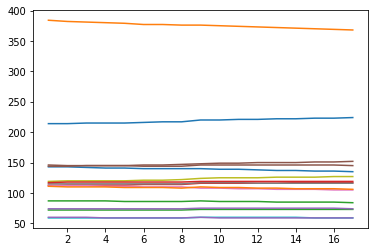

In [34]:
data_reshaped = df_sel_null_col['ludnosc_na_1km2'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.savefig('dane_pdf/dane_stat/ludnosc_na_1km2_all.pdf',  bbox_inches='tight')

In [35]:
def lq_lin(x, a, b):
    return x*a + b 

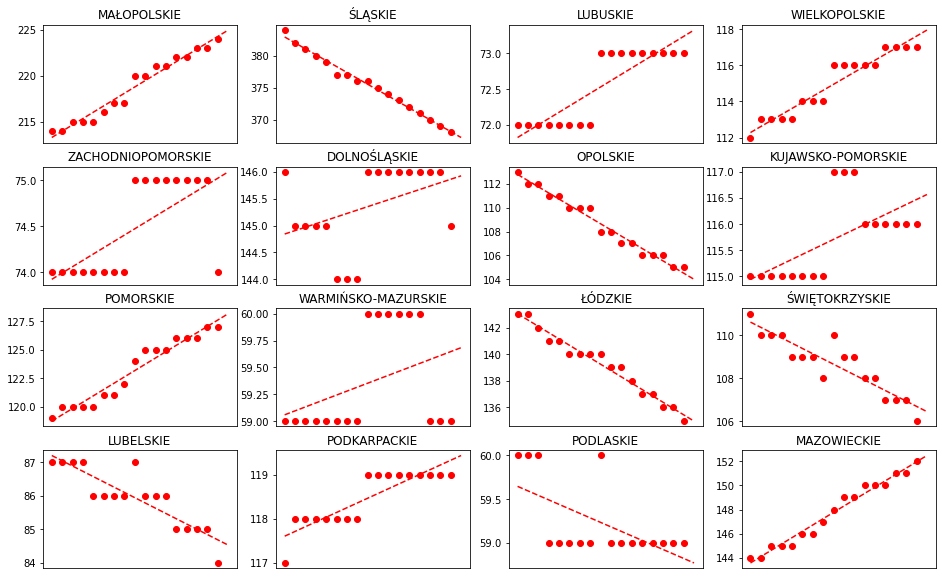

In [36]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,10))
 
for w in range(data_reshaped.shape[1]):
    (a,b), pcov = curve_fit(lq_lin, x, data_reshaped[1:,w], p0=[1,1])
    xmodel = np.arange(18)
    ymodel = lq_lin(xmodel, a, b)
    
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[1:,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_xticks([]) 
    ax1.set_title(woj[w])
    #plt.xticks(range(18), rotation=45)
    #ax.set_xticklabels(xlabels, rotation=40, ha=ha[n])
    #stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/ludnosc_na_1km2.pdf',  bbox_inches='tight')

In [37]:
for w in range(data_reshaped.shape[1]):
    stat_list_org[0]['ludnosc_na_1km2'][w] = data_reshaped[1,w]
    #stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.show()

### udzial_wiek_produkcyjny

In [38]:
def lq(x, a, b, c):
    return x*x*a + x*b + c

x = np.arange(17)

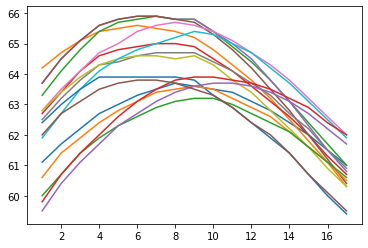

In [39]:
data_reshaped = df_sel_null_col['udzial_wiek_produkcyjny'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.savefig('dane_pdf/dane_stat/udzial_wiek_produkcyjny_all.pdf',  bbox_inches='tight')

In [40]:
data_reshaped.shape

(18, 16)

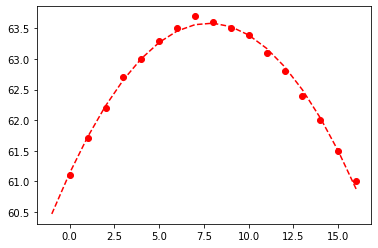

In [41]:
(a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,0], p0=[0.05,0.05,0.05])
xmodel = np.arange(-1,17)
ymodel = lq(xmodel, a, b, c)
fig, ax1 = plt.subplots()
ax1.plot(x, data_reshaped[1:,0], "ro", label="Experiment")
ax1.plot(xmodel,ymodel, "r--", label="Model")
plt.show()

a=-0.0404+-0.0008  b=0.6294+-0.0128  c=61.1345+-0.0442  r2=0.99 MSE=0.0038
a=-0.0452+-0.0013  b=0.4576+-0.021  c=64.3395+-0.0724  r2=1.0 MSE=0.0102
a=-0.0555+-0.0023  b=0.7027+-0.0377  c=63.57+-0.1299  r2=0.99 MSE=0.0329
a=-0.0484+-0.0022  b=0.6113+-0.0358  c=62.9714+-0.1234  r2=0.98 MSE=0.0297
a=-0.0542+-0.0017  b=0.6516+-0.0276  c=63.9382+-0.0953  r2=0.99 MSE=0.0177
a=-0.0557+-0.0019  b=0.6485+-0.0314  c=63.9616+-0.1082  r2=0.99 MSE=0.0229
a=-0.0502+-0.0014  b=0.7323+-0.0235  c=62.881+-0.081  r2=0.99 MSE=0.0128
a=-0.0454+-0.0013  b=0.6011+-0.022  c=62.695+-0.076  r2=0.99 MSE=0.0113
a=-0.0458+-0.0015  b=0.5518+-0.0243  c=62.9417+-0.0839  r2=0.99 MSE=0.0137
a=-0.0534+-0.0012  b=0.8373+-0.0199  c=61.9745+-0.0688  r2=0.99 MSE=0.0092
a=-0.0427+-0.0018  b=0.4641+-0.0292  c=62.645+-0.1009  r2=0.99 MSE=0.0199
a=-0.0464+-0.001  b=0.7226+-0.016  c=60.666+-0.0551  r2=0.99 MSE=0.0059
a=-0.0449+-0.0008  b=0.7443+-0.0135  c=60.0407+-0.0466  r2=1.0 MSE=0.0042
a=-0.0466+-0.001  b=0.8695+-0.0159  c=5

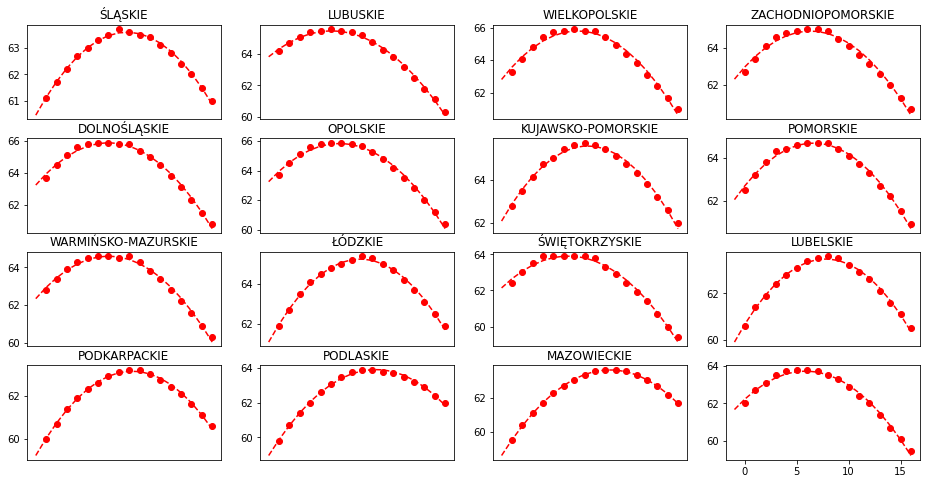

In [42]:
fig = plt.figure(1, figsize=(16,8))

for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))

    print("%s" % " ".join(starmap("{}={}+-{} ".format,
                zip(['a','b','c'],
                    np.round([a,b,c],4), 
                    np.round(perr,4)))) + 
          ' r2={r}'.format(r=np.round(r2_score(data_reshaped[1:,w], ymodel[1:]),2)) +
         ' MSE={mse}'.format(mse=np.round(np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/(len(ymodel)-1),4)))
    ax1.set_xticks([]) 
    ax1.set_title(woj[w])
    
    stat_list_org[0]['udzial_wiek_produkcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[1:,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    #ax1.set_yticks([]) 
    #plt.xticks(range(18), rotation=45)
plt.savefig('dane_pdf/dane_stat/udzial_wiek_produkcyjny.pdf',  bbox_inches='tight')

### udzial_wiek_przedprodukcyjny

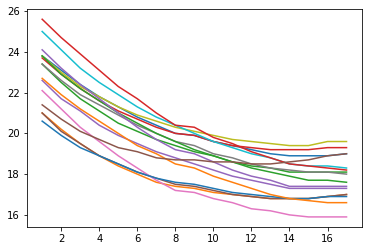

In [43]:
data_reshaped = df_sel_null_col['udzial_wiek_przedprodukcyjny'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.savefig('dane_pdf/dane_stat/udzial_wiek_przedprodukcyjny_all.pdf',  bbox_inches='tight')

a=0.0247+-0.0009  b=-0.6886+-0.0144  c=23.7117+-0.0497  r2=1.0
a=0.0275+-0.0015  b=-0.6676+-0.0241  c=20.7814+-0.0833  r2=0.99
a=0.0256+-0.0013  b=-0.7197+-0.0222  c=23.1561+-0.0767  r2=1.0
a=0.0268+-0.0011  b=-0.6848+-0.0178  c=23.5252+-0.0614  r2=1.0
a=0.0229+-0.0011  b=-0.6833+-0.0177  c=22.4011+-0.0611  r2=1.0
a=0.0254+-0.0013  b=-0.6359+-0.0209  c=20.743+-0.0719  r2=0.99
a=0.0309+-0.0015  b=-0.8628+-0.0255  c=21.9505+-0.0879  r2=1.0
a=0.0215+-0.0008  b=-0.6689+-0.0128  c=23.2596+-0.0441  r2=1.0
a=0.0252+-0.001  b=-0.6493+-0.0174  c=23.6078+-0.06  r2=1.0
a=0.0261+-0.0009  b=-0.8236+-0.0155  c=24.8474+-0.0533  r2=1.0
a=0.0204+-0.0011  b=-0.5416+-0.0178  c=20.41+-0.0613  r2=0.99
a=0.0222+-0.0008  b=-0.7311+-0.0128  c=22.61+-0.044  r2=1.0
a=0.0227+-0.0007  b=-0.7392+-0.0114  c=23.6543+-0.0393  r2=1.0
a=0.0276+-0.0012  b=-0.8953+-0.0205  c=25.5375+-0.0708  r2=1.0
a=0.0291+-0.0009  b=-0.8818+-0.0146  c=24.0568+-0.0503  r2=1.0
a=0.0244+-0.0015  b=-0.5152+-0.0242  c=21.1487+-0.0836  r2=0.

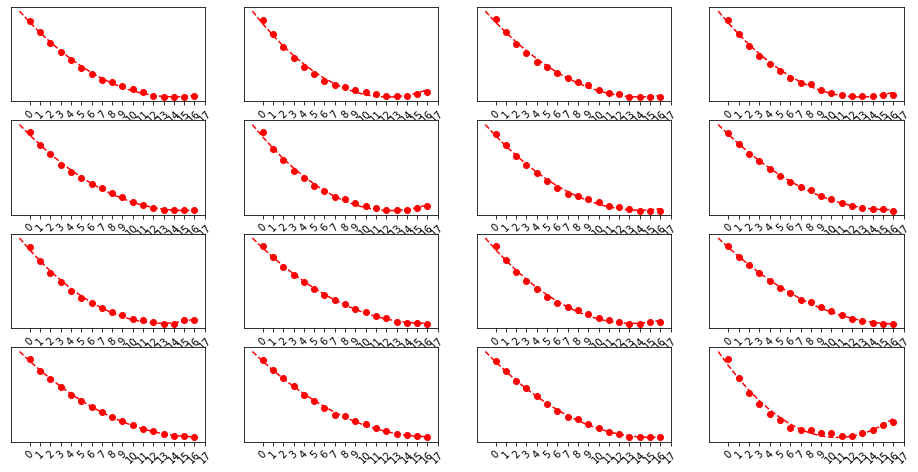

In [44]:
fig = plt.figure(1, figsize=(16,8))

for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))
    print("%s" % " ".join(starmap("{}={}+-{} ".format,
            zip(['a','b','c'],
                np.round([a,b,c],4), 
                np.round(perr,4)))) + ' r2={r}'.format(r=np.round(r2_score(data_reshaped[1:,w], ymodel[1:]),2)))
    stat_list_org[0]['udzial_wiek_przedprodukcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[1:,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_yticks([]) 
  
    plt.xticks(range(18), rotation=45)
plt.savefig('dane_pdf/dane_stat/udzial_wiek_przedprodukcyjny.pdf',  bbox_inches='tight')

### udzial_wiek_poprodukcyjny

In [45]:
df_sel_null_col.columns

Index(['przestepstwa_ogolem', 'udzial_wiek_przedprodukcyjny', 'socjal_500plus',
       'udzial_wiek_produkcyjny', 'dochody_brutto_na_mieszkanca',
       'ludnosc_na_1km2'],
      dtype='object')

In [46]:
data_reshaped = df_sel_null_col['udzial_wiek_poprodukcyjny'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.savefig('dane_pdf/dane_stat/udzial_wiek_poprodukcyjny_all.pdf',  bbox_inches='tight')

KeyError: 'udzial_wiek_poprodukcyjny'

a=0.0247+-0.0009  b=-0.6886+-0.0144  c=23.7117+-0.0497  r2=1.0 MSE=0.0048
a=0.0275+-0.0015  b=-0.6676+-0.0241  c=20.7814+-0.0833  r2=0.99 MSE=0.0135
a=0.0256+-0.0013  b=-0.7197+-0.0222  c=23.1561+-0.0767  r2=1.0 MSE=0.0115
a=0.0268+-0.0011  b=-0.6848+-0.0178  c=23.5252+-0.0614  r2=1.0 MSE=0.0074
a=0.0229+-0.0011  b=-0.6833+-0.0177  c=22.4011+-0.0611  r2=1.0 MSE=0.0073
a=0.0254+-0.0013  b=-0.6359+-0.0209  c=20.743+-0.0719  r2=0.99 MSE=0.0101
a=0.0309+-0.0015  b=-0.8628+-0.0255  c=21.9505+-0.0879  r2=1.0 MSE=0.0151
a=0.0215+-0.0008  b=-0.6689+-0.0128  c=23.2596+-0.0441  r2=1.0 MSE=0.0038
a=0.0252+-0.001  b=-0.6493+-0.0174  c=23.6078+-0.06  r2=1.0 MSE=0.007
a=0.0261+-0.0009  b=-0.8236+-0.0155  c=24.8474+-0.0533  r2=1.0 MSE=0.0055
a=0.0204+-0.0011  b=-0.5416+-0.0178  c=20.41+-0.0613  r2=0.99 MSE=0.0073
a=0.0222+-0.0008  b=-0.7311+-0.0128  c=22.61+-0.044  r2=1.0 MSE=0.0038
a=0.0227+-0.0007  b=-0.7392+-0.0114  c=23.6543+-0.0393  r2=1.0 MSE=0.003
a=0.0276+-0.0012  b=-0.8953+-0.0205  c=25.5375

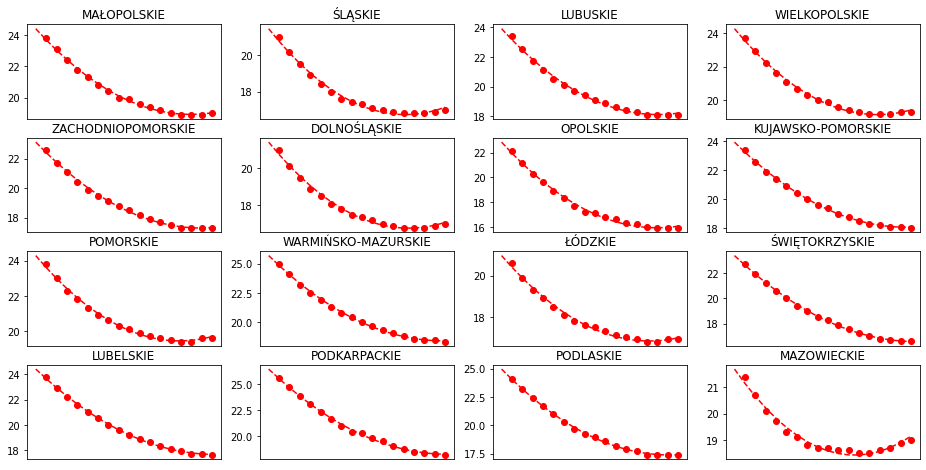

In [50]:
fig = plt.figure(1, figsize=(16,8))

for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))
    print("%s" % " ".join(starmap("{}={}+-{} ".format,
            zip(['a','b','c'],
                np.round([a,b,c],4), 
                np.round(perr,4)))) + 
          ' r2={r}'.format(r=np.round(r2_score(data_reshaped[1:,w], ymodel[1:]),2)) +
         ' MSE={mse}'.format(mse=np.round(np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/(len(ymodel)-1),4)))
    
    stat_list_org[0]['udzial_wiek_poprodukcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[1:,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    #ax1.set_yticks([]) 
    #plt.xticks(range(18), rotation=45)
    ax1.set_xticks([]) 
    ax1.set_title(woj[w])
plt.savefig('dane_pdf/dane_stat/udzial_wiek_poprodukcyjny.pdf',  bbox_inches='tight')

### przestepstwa_ogolem

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

In [52]:
def lq_sin(x, a, b, c, d):
    return np.sin(x/a*np.pi)*b + x*c + d

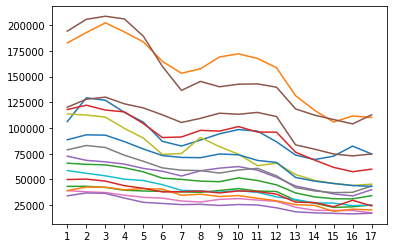

In [53]:
data_reshaped = df_sel_null_col['przestepstwa_ogolem'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.xticks(range(1,18))
plt.savefig('dane_pdf/dane_stat/przestepstwa_ogolem_all.pdf',  bbox_inches='tight')

#### MINMAX rescaling

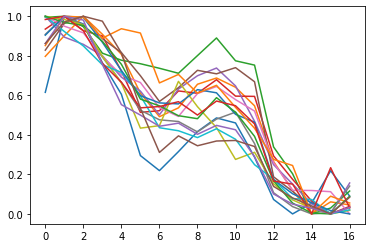

In [54]:
minmax_data_reshaped = preprocessing.minmax_scale(data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1))
plt.plot(minmax_data_reshaped)
plt.savefig('dane_pdf/dane_stat/przestepstwa_ogolem_all_minmax.pdf',  bbox_inches='tight')

#### Comparing each year with best line

In [55]:
notnull_data_reshaped = data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1)

In [56]:
mx = notnull_data_reshaped.max(0)
mn = notnull_data_reshaped.min(0)

a=3.7078+-0.072  b=0.2128+-0.0323  c=-0.0453+-0.0048  d=0.7545+-0.0435  r2=0.93
a=3.9744+-0.0836  b=0.1749+-0.0305  c=-0.0502+-0.0044  d=0.9353+-0.0399  r2=0.95
a=3.9771+-0.1771  b=0.1531+-0.0565  c=-0.052+-0.0081  d=1.0417+-0.0738  r2=0.84
a=4.011+-0.0853  b=0.1561+-0.0273  c=-0.0519+-0.0039  d=0.9564+-0.0356  r2=0.96
a=3.8637+-0.1203  b=0.1362+-0.0351  c=-0.0511+-0.0051  d=0.945+-0.0462  r2=0.92
a=3.9709+-0.127  b=0.1712+-0.0454  c=-0.0534+-0.0065  d=0.9922+-0.0594  r2=0.9
a=3.9631+-0.1073  b=0.1099+-0.0247  c=-0.0539+-0.0035  d=0.9613+-0.0323  r2=0.96
a=3.803+-0.0534  b=0.1397+-0.0159  c=-0.0575+-0.0023  d=0.9169+-0.0212  r2=0.99
a=3.4904+-0.129  b=0.0892+-0.0256  c=-0.0658+-0.0038  d=0.9748+-0.0348  r2=0.96
a=3.8215+-0.131  b=0.0582+-0.0163  c=-0.0609+-0.0024  d=0.9263+-0.0216  r2=0.98
a=3.8779+-0.0842  b=0.1181+-0.0213  c=-0.0598+-0.0031  d=0.9917+-0.028  r2=0.98
a=3.9864+-0.3997  b=0.0488+-0.0405  c=-0.0623+-0.0058  d=1.0778+-0.0529  r2=0.92
a=3.8547+-0.0486  b=0.1238+-0.0129  c=

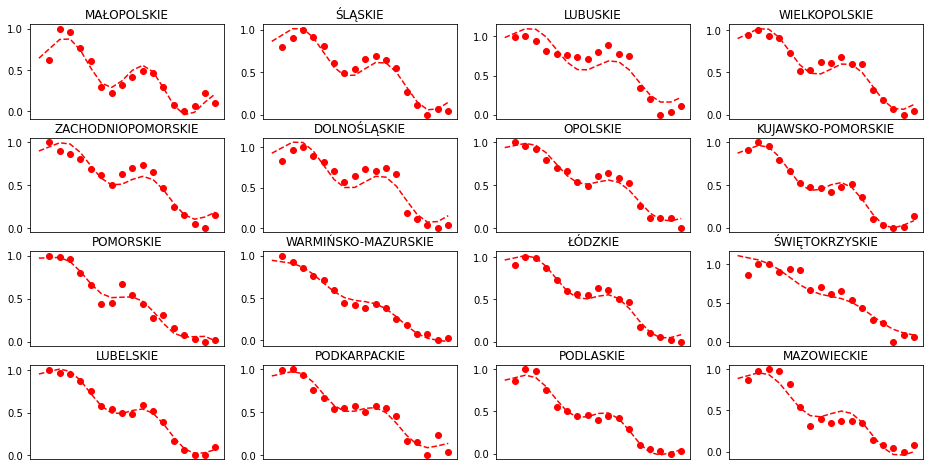

In [57]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq_sin, 
                                x, 
                                minmax_data_reshaped[:,w], # data_reshaped[1:,w], 
                                p0=[4,6,-1,1], maxfev = 100000)
    xmodel = np.arange(-1,17)
    ymodel = lq_sin(xmodel, a,b,c,d)
    perr = np.sqrt(np.diag(pcov))
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, 
             minmax_data_reshaped[:,w],#data_reshaped[1:,w], 
             "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    #ax1.set_yticks([]) 
    plt.xticks(range(-1,17), rotation=45)
    print("%s" % " ".join(starmap("{}={}+-{} ".format,
            zip(['a','b','c','d'],
                np.round([a,b,c,d],4), 
                np.round(perr,4)))) + 
          ' r2={r}'.format(r=np.round(r2_score(data_reshaped[1:,w], ymodel[1:]*(mx[w]-mn[w])+mn[w]),2)))

    stat_list_org[0]['przestepstwa_ogolem'][w] = ymodel[0]*(mx[w]-mn[w])+mn[w]
    ax1.set_xticks([]) 
    ax1.set_title(woj[w])
plt.savefig('dane_pdf/dane_stat/przestepstwa_ogolem.pdf',  bbox_inches='tight')

### dochody_brutto_na_mieszkanca

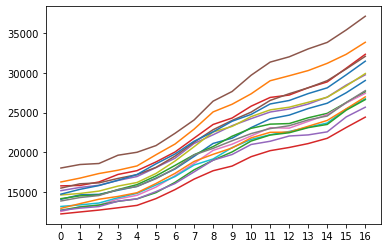

In [58]:
data_reshaped = df_sel_null_col['dochody_brutto_na_mieszkanca'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.xticks(range(17))
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca_all.pdf',  bbox_inches='tight')

In [59]:
def lq3(x, a, b, c, d):
    return x*x*x*a + x*x*b + x*c + d

def lq1(x, a, b):
    return x*a + b 

x = np.arange(17)

a=-4.2205+-1.2602  b=113.7277+-30.713  c=155.5008+-207.6451  d=14011.5232+-371.9526  r2=0.99


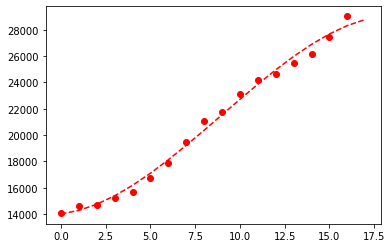

In [60]:
(a,b,c,d), pcov = curve_fit(lq3, x, data_reshaped[:-1,0], p0=[1,1,1,1])
xmodel = np.arange(18)
ymodel = lq3(xmodel, a, b, c,d)
fig, ax1 = plt.subplots()
ax1.plot(x, data_reshaped[:-1,0], "ro", label="Experiment")
ax1.plot(xmodel,ymodel, "r--", label="Model")
perr = np.sqrt(np.diag(pcov))
print("%s" % " ".join(starmap("{}={}+-{} ".format,
        zip(['a','b','c','d'],
            np.round([a,b,c,d],4), 
            np.round(perr,4)))) + ' r2={r}'.format(r=np.round(r2_score(data_reshaped[:-1,0], ymodel[:-1]),2)))

plt.show()

a=983.3358+-32.7525  b=12805.0196+-307.2458  r2=0.98


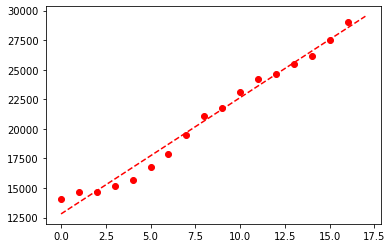

In [61]:
(a,b), pcov = curve_fit(lq1, x, data_reshaped[:-1,0], p0=[1,1])
xmodel = np.arange(18)
ymodel = lq1(xmodel, a, b)
fig, ax1 = plt.subplots()
ax1.plot(x, data_reshaped[:-1,0], "ro", label="Experiment")
ax1.plot(xmodel,ymodel, "r--", label="Model")
perr = np.sqrt(np.diag(pcov))
print("%s" % " ".join(starmap("{}={}+-{} ".format,
        zip(['a','b'],
            np.round([a,b],4), 
            np.round(perr,4)))) + ' r2={r}'.format(r=np.round(r2_score(data_reshaped[:-1,0], ymodel[:-1]),2)))

plt.show()

a=-4.2205+-1.2602  b=113.7277+-30.713  c=155.5008+-207.6451  d=14011.5232+-371.9526  r2=0.99
a=-6.477+-1.381  b=162.1574+-33.6578  c=116.983+-227.5543  d=16234.5397+-407.6159  r2=0.99
a=-3.2168+-1.5121  b=76.6127+-36.8539  c=409.6794+-249.1631  d=13801.291+-446.3234  r2=0.99
a=-3.7362+-1.5161  b=100.7572+-36.9494  c=351.2682+-249.8086  d=15380.0836+-447.4798  r2=0.99
a=-3.2626+-1.4516  b=83.7614+-35.3787  c=380.0242+-239.1894  d=14892.3973+-428.4578  r2=0.99
a=-4.8817+-1.2116  b=136.0092+-29.5297  c=69.9883+-199.645  d=15477.8916+-357.6221  r2=0.99
a=-3.4318+-1.5201  b=84.4907+-37.0492  c=427.1905+-250.4834  d=12324.5181+-448.6887  r2=0.99
a=-1.8705+-1.4936  b=49.6225+-36.4026  c=525.7162+-246.1116  d=13531.0908+-440.8574  r2=0.99
a=-4.9722+-1.7963  b=120.9004+-43.7793  c=255.296+-295.9843  d=14262.1146+-530.1938  r2=0.99
a=-2.7336+-1.3748  b=72.4391+-33.5066  c=364.4723+-226.5326  d=12832.3437+-405.7857  r2=0.99
a=-2.5117+-1.276  b=67.0117+-31.0979  c=586.455+-210.2472  d=14479.5934+-

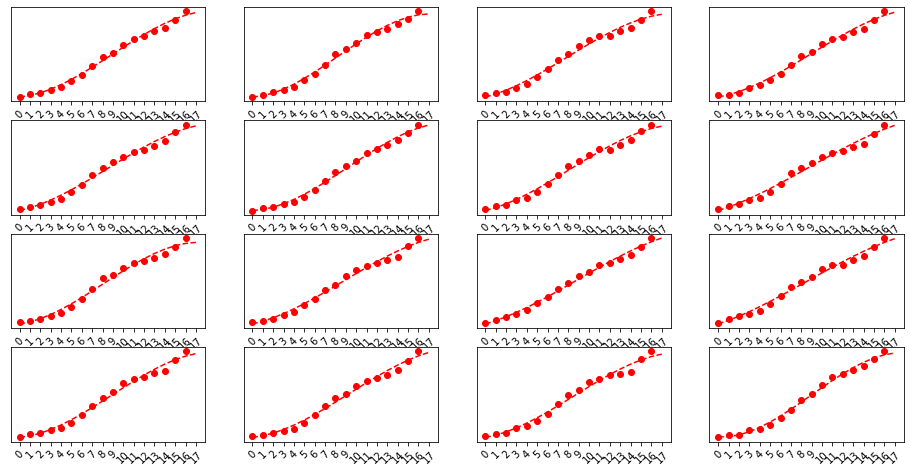

In [62]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq3, x, data_reshaped[:-1,w], p0=[1,1,1,1])
    xmodel = np.arange(18)
    ymodel = lq3(xmodel, a, b, c,d)
    perr = np.sqrt(np.diag(pcov))
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[:-1,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_yticks([]) 
    plt.xticks(range(18), rotation=45)
    print("%s" % " ".join(starmap("{}={}+-{} ".format,
            zip(['a','b','c','d'],
                np.round([a,b,c,d],4), 
                np.round(perr,4)))) + ' r2={r}'.format(r=np.round(r2_score(data_reshaped[:-1,w], ymodel[:-1]),2)))

    stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca.pdf',  bbox_inches='tight')

a=983.3358+-32.7525  b=12805.0196+-307.2458  r2=0.98
a=1189.3971+-39.734  b=14878.0588+-372.7377  r2=0.98
a=879.5343+-30.2342  b=13284.4902+-283.622  r2=0.98
a=1085.3775+-33.9892  b=14308.8627+-318.8465  r2=0.99
a=953.4951+-30.0833  b=14125.9216+-282.2066  r2=0.99
a=1098.9436+-37.7954  b=13903.8039+-354.5527  r2=0.98
a=972.5784+-30.9708  b=11662.8431+-290.5319  r2=0.99
a=880.1029+-27.7371  b=13027.6471+-260.1973  r2=0.99
a=1021.2304+-39.0279  b=13364.098+-366.1137  r2=0.98
a=881.098+-28.1019  b=12099.8039+-263.6196  r2=0.98
a=1068.4044+-26.1496  b=13788.3529+-245.3046  r2=0.99
a=882.7181+-26.5884  b=12283.4314+-249.4209  r2=0.99
a=911.6985+-34.2648  b=11502.2353+-321.4326  r2=0.98
a=794.1422+-28.5531  b=11074.5098+-267.8515  r2=0.98
a=846.6348+-31.917  b=11655.8627+-299.4079  r2=0.98
a=1294.1642+-49.1201  b=16025.8628+-460.7876  r2=0.98


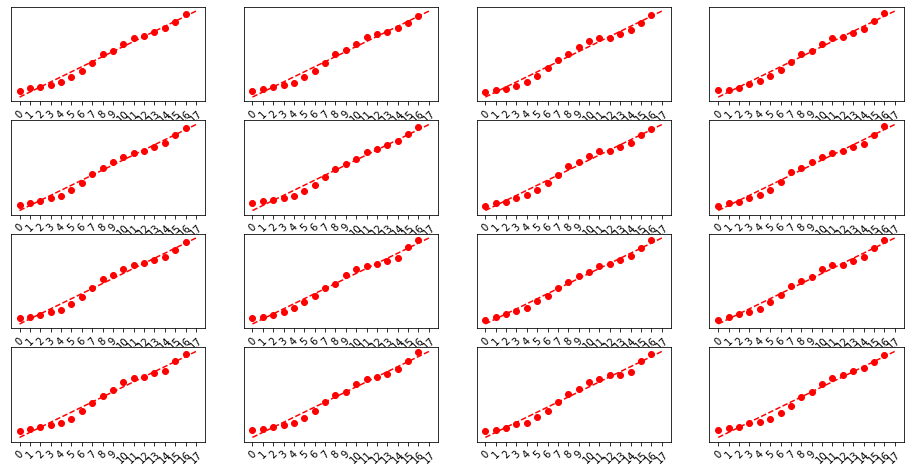

In [63]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b), pcov = curve_fit(lq1, x, data_reshaped[:-1,w], p0=[1,1])
    xmodel = np.arange(18)
    ymodel = lq1(xmodel, a, b)
    perr = np.sqrt(np.diag(pcov))
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[:-1,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    plt.xticks(range(18), rotation=45)
    ax1.set_yticks([]) 
    print("%s" % " ".join(starmap("{}={}+-{} ".format,
            zip(['a','b'],
                np.round([a,b],4), 
                np.round(perr,4)))) + ' r2={r}'.format(r=np.round(r2_score(data_reshaped[:-1,w], ymodel[:-1]),2)))

    stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca_simplermodel.pdf',  bbox_inches='tight')

## Creating new stat data

In [64]:
stat_list_org[0].max(0)

emeryci_i_rencisci                  1.169706e+06
bezrobocie_zarejsestrowane          3.461180e+05
bezrobocie_zarejsestrowane_gminy             NaN
malzenstwa_zawarte                  2.619400e+04
ludnosc_na_1km2                     3.840000e+02
dochody_gminy                       9.939423e+09
dochody_na_mieszkanca                        NaN
wyksztalcenie_wyzsze                3.200000e+00
wyksztalcenie_gim_pod_nizsze        3.290000e+01
wyksztalcenie_srednie               3.380000e+01
rozwody_powiat                      6.661000e+03
udzial_wiek_przedprodukcyjny        2.646029e+01
udzial_wiek_produkcyjny             6.383676e+01
udzial_wiek_poprodukcyjny           2.646029e+01
praca_najemna                       3.956700e+02
praca_wlasny_rachunek               8.107000e+01
socjal_500plus                               NaN
socjal                              2.537100e+02
dochody_brutto_na_mieszkanca        1.800900e+04
PKB_na_1_mieszkanca                 3.132500e+04
przestepstwa_ogolem 

In [65]:
for s in stat_list_org:
    s['ludnosc'] = s['ludnosc_na_1km2']*s['powierzchnnia_km2']
    s['przestepstwa_ludnosc'] = s['przestepstwa_ogolem']/s['ludnosc']
    s['emeryci_i_rencisci_ludnosc'] = s['emeryci_i_rencisci']/s['ludnosc']
    s['bezrobocie_zarejsestrowane_ludnosc'] = s['bezrobocie_zarejsestrowane']/s['ludnosc']
    s['malzenstwa_zawarte_ludnosc'] = s['malzenstwa_zawarte']/s['ludnosc']
    s['dochody_gminy_ludnosc'] = s['dochody_gminy']/s['ludnosc']
    s['rozwody_powiat_ludnosc'] = s['rozwody_powiat']/s['ludnosc']
    s['rozwody_malzenstwa'] = s['rozwody_powiat']/s['malzenstwa_zawarte']

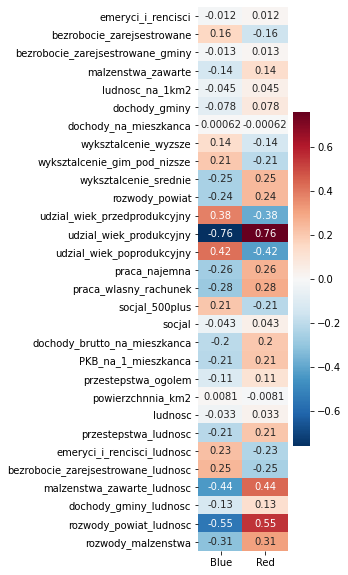

In [66]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(2,10))
sn.heatmap(pool_stat_df_org.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

## Rescale the data

In [67]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [68]:
stat_list_minmax = stat_list_org.copy()
stat_list_mean = stat_list_org.copy()

In [69]:
#MINMAX scaling
for st in range(len(stat_list_org)):
    stat_list_minmax[st] = stat_list_org[st][col_not_na0 & col_not_na17]
    # min max normalization
    stat_list_minmax[st] = (stat_list_minmax[st]-stat_list_minmax[st].min(0)) / (stat_list_minmax[st].max(0)-stat_list_minmax[st].min(0))

In [70]:
for st in range(len(stat_list_org)):
    stat_list_mean[st] = stat_list_org[st][col_not_na0 & col_not_na17]
    # nrmalization mean (around 0)
    stat_list_mean[st] = (stat_list_mean[st]-stat_list_mean[st].mean(0)) / (stat_list_mean[st].std(0))

In [71]:
stat_list = stat_list_mean if (True) else stat_list_minmax

## Examining stat data

In [72]:
len(stat_list)

18

In [73]:
len(stat_list_org)

18

In [74]:
len(pool_d[:-1])

18

In [75]:
pool_stat_m = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_mean, pool_d[1:])]
pool_stat_mm = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_minmax, pool_d[1:])]

In [76]:
pool_stat_df_m = pd.concat(pool_stat_m).reset_index(drop=True)
pool_stat_df_mm = pd.concat(pool_stat_mm).reset_index(drop=True)

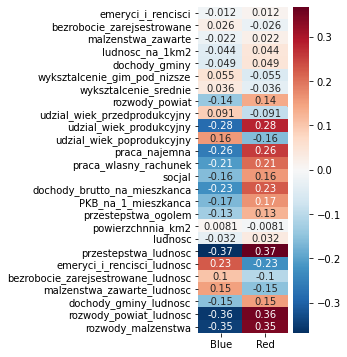

In [77]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_m.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

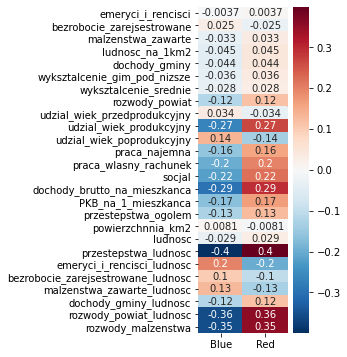

In [78]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_mm.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [79]:
potential_cols = pool_stat_df_m.corr().iloc[:-2,-1].abs()
potential_cols = potential_cols[potential_cols>0.1]
high_cols = potential_cols.index.values.tolist()

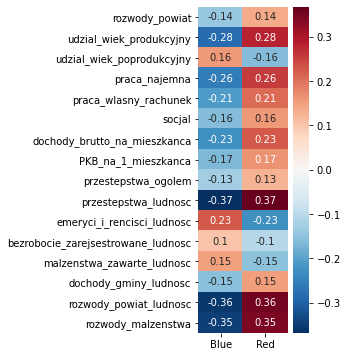

In [80]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_m.corr().loc[high_cols,['Blue','Red']], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [81]:
high_cols = [#'rozwody_powiat',
 'udzial_wiek_produkcyjny',
 ###'udzial_wiek_poprodukcyjny',
 'praca_najemna',
 'praca_wlasny_rachunek',
 'socjal',
 'dochody_brutto_na_mieszkanca',
 'PKB_na_1_mieszkanca',
 #'przestepstwa_ogolem',
 'przestepstwa_ludnosc',
 'emeryci_i_rencisci_ludnosc',
 'bezrobocie_zarejsestrowane_ludnosc',
 'malzenstwa_zawarte_ludnosc',
 'dochody_gminy_ludnosc',
 'rozwody_powiat_ludnosc',
 'rozwody_malzenstwa'
]

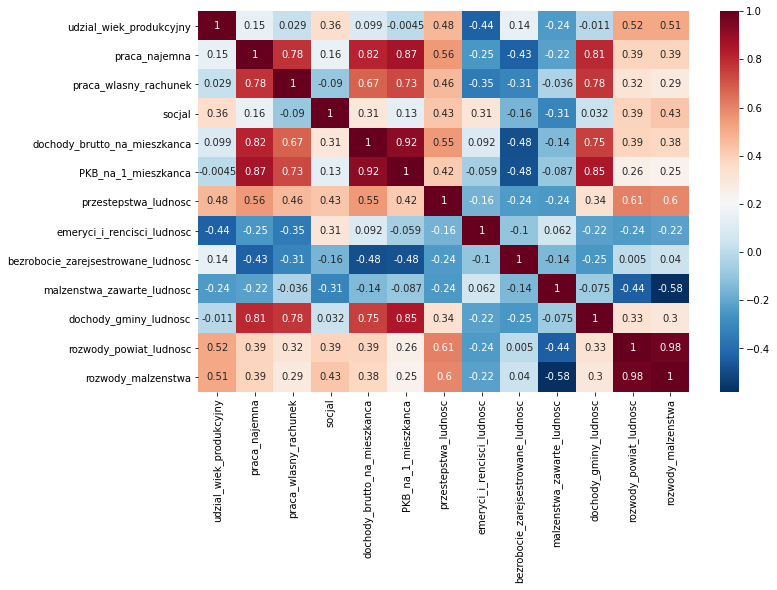

In [82]:
fig, ax = plt.subplots(figsize=(11,7))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,high_cols], annot=True, cmap='RdBu_r')
plt.savefig('dane_pdf/dane_stat/corr_between.pdf',  bbox_inches='tight')

In [83]:
high_cols = [
 'udzial_wiek_produkcyjny',
 #'udzial_wiek_poprodukcyjny',
 'praca_najemna',
 #'praca_wlasny_rachunek',
 'socjal',
 #'dochody_brutto_na_mieszkanca',
 #'PKB_na_1_mieszkanca',
 'przestepstwa_ludnosc',
 'emeryci_i_rencisci_ludnosc',
 'bezrobocie_zarejsestrowane_ludnosc',
 'malzenstwa_zawarte_ludnosc'
 #'dochody_gminy_ludnosc',
 #'rozwody_powiat_ludnosc'
 #'rozwody_malzenstwa'
]

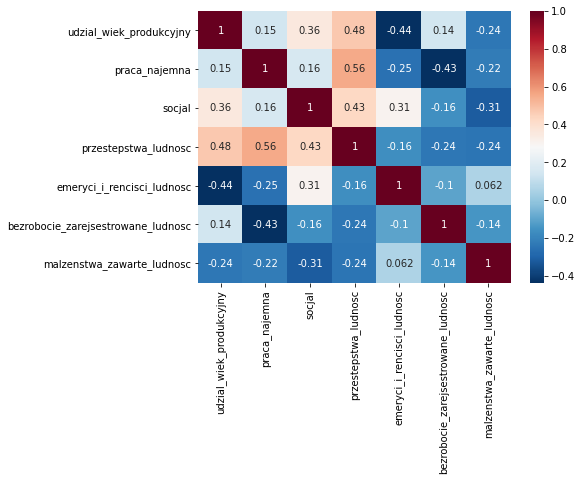

In [84]:
fig, ax = plt.subplots(figsize=(7,5))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,high_cols], annot=True, cmap='RdBu_r')
plt.savefig('dane_pdf/dane_stat/corr_between_choosen.pdf',  bbox_inches='tight')

In [85]:
stat_list = [st.loc[:,high_cols] for st in stat_list]

# Model

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [86]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(len(stat_list)):
    # iterate over districts
    tmp_x = []
    st_data = stat_list[y]
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(lo[0]/lo.sum())
        tmp_y.append(avg_n)
                
        tmp_x.append(tmp_y)
    X.append(tmp_x)

In [87]:
X = np.array(X)
X.shape

(18, 16, 9)

## Prepare Y

In [88]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [89]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [90]:
X.shape

(18, 16, 9)

### Models with percentage of Blue support per district

In [91]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    OUTPUT:
    y - predicted value in (0,1)
    '''
    #d0 = x.shape[0] if (len(x.shape) == 3) else 1
    #d1 = x.shape[-1] 
    
    #a = np.repeat(a, d0, 0)
    #x = x.reshape(-1, d1) 
    
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x*a,1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x*a,1,keepdims=True)))**2 *
          np.exp(-np.sum(x*a,1,keepdims=True)) *
          x)
    return y1

In [92]:
"""
def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    m = np.sign(y - model_percent(a,x))
    y1 =m*(2 * 
          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *
          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *
          x) 
    return y1
"""

"\ndef grad_percent(a,x,y):\n    '''\n    INPUT:\n    a - vector of weights 16x14\n    x - vector of input data 18x16x14\n    '''\n    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2\n    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2\n    d0 = x.shape[0] if (len(x.shape) == 3) else 1\n    d1 = x.shape[-1] \n    \n    a = np.repeat(a, d0, 0)\n    x = x.reshape(-1, d1)\n    y = y.reshape(-1, 1)\n    m = np.sign(y - model_percent(a,x))\n    y1 =m*(2 * \n          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * \n          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *\n          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *\n          x) \n    return y1\n"

### Setup for testing model

In [93]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [94]:
st_data.shape

(16, 7)

In [95]:
def prepare_input(y, st_data):
    tmp_x = np.zeros((y.shape[0],st_data.shape[-1]+2))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(y[d,0])
        tmp_y.append(avg_n)
        
        tmp_x[d] = np.array(tmp_y)
    return(tmp_x)

In [96]:
def model(a,x,Y,st_list):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        st_data = stat_list[year-1]
        xi = prepare_input(y,st_list[year-1])
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

In [97]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
#av = np.random.rand(X.shape[1],X.shape[2])

step = 0.01
beta = 0.1
a_avg.shape

(16, 9)

## Use output -> next input (grad each step)

loss: 0.4906289545024343
loss: 0.17002010026561293
loss: 0.1472690774065525
loss: 0.13555895589200428
loss: 0.12907600317333556
loss: 0.12510285041927116
loss: 0.12228474034411396
loss: 0.12011615353459933
loss: 0.11842740416096191
loss: 0.11713147409028607


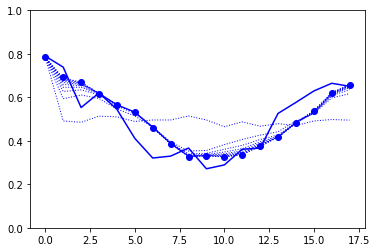

In [98]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.1 

loss_arr = np.zeros((10**3,))

loss_prev = np.inf

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)
    
    loss_arr[epoch] = loss_p
    #if loss_p < loss_prev:
    #    step = step*0.95
    #else:
    #    step = step*1.05
    
    #loss_prev = loss_p
            
    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        print('loss:', np.mean(l))
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

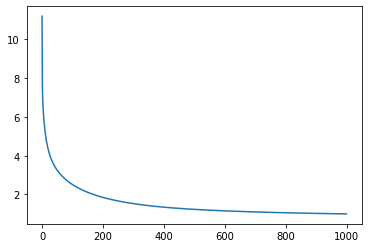

In [99]:
plt.plot(loss_arr)
plt.show()

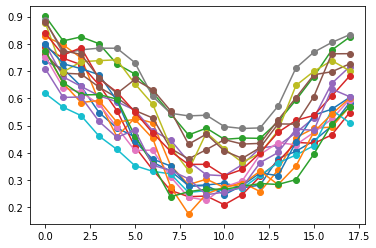

In [100]:
plt.plot(o.reshape(-1,16),'o-')
plt.show()

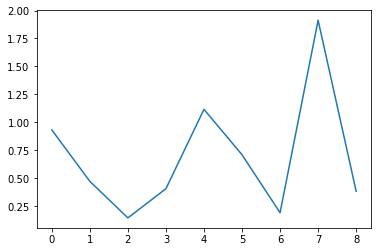

In [108]:
plt.plot(np.abs(a_step).mean(0))

In [112]:
for a, n in zip(np.abs(a_step).mean(0), stat_list[0].columns.values.tolist()+['last','neigh']):
    print(np.round(a,2),n)

0.93 udzial_wiek_produkcyjny
0.47 praca_najemna
0.14 socjal
0.4 przestepstwa_ludnosc
1.12 emeryci_i_rencisci_ludnosc
0.71 bezrobocie_zarejsestrowane_ludnosc
0.19 malzenstwa_zawarte_ludnosc
1.91 last
0.38 neigh


### Compare of parameters per each district

In [ ]:
plt.plot(np.abs(a_step.T), 'o-')
plt.xticks(range(a_step.shape[1]), ['prev','neigh']+high_cols, size='small',rotation=90)
plt.show()

In [ ]:
plt.plot(np.abs(a_step).mean(0), 'o-')
plt.errorbar(np.arange(9), np.abs(a_step).mean(0), e, linestyle='None', marker='', ecolor='tab:blue')
e = np.abs(a_step).std(0)
plt.xticks(range(a_step.shape[1]), ['prev','neigh']+high_cols, size='small',rotation=90)
plt.show()

In [ ]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 1

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

In [ ]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 10

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

## All at once + evolution strategies (TO DO)

# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
for epoch in range(10**3):
    grad = grad_percent(a_avg,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
a_avg.shape

In [ ]:
l_avg, o = model(a_avg,X,Y)
l_all, o = model(a_all,X,Y)
plt.plot(l_avg,'bo')
plt.plot(l_all,'ro')
plt.plot()

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI

In [ ]:
(a_avg-a_all).max()